# Introducing Tensorflow

Be sure to "conda install tensorflow" or "conda install tensorflow-gpu" first!

## The world's simplest Tensorflow application

Let's begin by writing a really simple program to illustrate Tensorflow's main concepts. We'll set up two Variables, named "a" and "b", which each contain a tensor which contains a single value - the number 1, and the number 2.

We then create a graph "f" that adds these two tensors together. But "f = a + b" just creates the graph; it doesn't actually perform the addition yet.

Next we need to initialize any global variables before we run the graph.

And finally, we create a Tensorflow Session object, run our variable initializer, and execute the graph with eval(). 

This returns the sum of 1 + 2 in a rather complex, yet highly scalable manner :)


In [1]:
import tensorflow as tf

a = tf.Variable(1, name="a")
b = tf.Variable(2, name="b")
f = a + b

tf.print("The sum of a and b is", f)

ImportError: Traceback (most recent call last):
  File "C:\Users\gdhillon\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

## And now for something more interesting: Handwriting recognition

The standard example for machine learning these days is the MNIST data set, a collection of 70,000 handwriting samples of the numbers 0-9. Our challenge - to predict which number each handwritten image represents.

Although we'll talk about neural networks that are specifically well suited for image recognition later, we actually don't need to go there for this relatively simple task. We can achieve decent results without a whole lot of code.

Each image is 28x28 grayscale pixels, so we can treat each image as just a 1D array, or tensor, of 784 numbers. As long as we're consistent in how we flatten each image into an array, it'll still work. Yes, it would be even better if we could preserve the 2D structure of the data while training - but we'll get there later.

Let's start by importing the data set, which conveniently is part of tensorflow itself. We will reshape the images into the 1D arrays of 784 pixels that we expect, and the label data into one-hot-encoded categorical format (which we will convert during our loss function defination), which we'll talk about in a second:

In [1]:
# Prepare MNIST data.
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# MNIST dataset parameters
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28*28)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

ImportError: Traceback (most recent call last):
  File "C:\Users\gdhillon\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

MNIST provides 60,000 samples in a training data set, and 10,000 samples in a test data set.

If you're new to the concept of train/test - it's important to evaluate the performance of our neural network using data it's never seen before. Otherwise it's kinda like giving students a math test for problems they already have the answers for. So, we use a completely different set of images to train our neural network from the images used for testing its accuracy.

The training images are therefore a tensor of shape [60,000, 784] - 60,000 instances of 784 numbers that represent each image. The training labels are a one-dimensional tensor of 60,000 labels that range from 0 to 9.

Let's define a little function to let us visualize what the input data looks like, and pick some random training image to see what it is we're up against:


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

def display_sample(num):
    #Print this sample's label 
    label = y_train[num] 
    
    #Reshape the 784 values to a 28x28 image
    image = x_train[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1000)

Matplotlib is building the font cache; this may take a moment.


NameError: name 'y_train' is not defined

So, you can see the training label for image #1000, as well as what this particular sample looks like. You can tell that some of the training data would even be challenging for a human to classify!

Go ahead and try different input images to get a feel of the data we're given. Any value between 0 and 60,000 will work.

As a reminder, we're flattening each image to a 1D array of 784 (28 x 28) numerical values. Each one of those values will be an input node into our deep neural network. Let's visualize how the data is being fed into it just to drive that point home:

In [3]:
images = x_train[0].reshape([1,784])
for i in range(1, 500):
    images = np.concatenate((images, x_train[i].reshape([1,784])))
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

NameError: name 'x_train' is not defined

This is showing the first 500 training samples, one on each row. Imagine each pixel on each row getting fed into the bottom layer of a neural network 768 neurons (or "units") wide as we train our neural network.

We will now define few training parameters (or "hyperparameters") and use tf.data API to shuffle our data and divide it into batches. Think of these as parameters - we build up our neural network model without knowledge of the actual data that will be fed into it; we just need to construct it in such a way that our data will fit in.

We'll use a Dataset within Tensorflow to wrap our traning features and labels, and use functions of the Dataset to randomly shuffle it and batch it up into smaller chunks for each iteration of training.

In [9]:
# Training parameters.
learning_rate = 0.001
training_steps = 3000
batch_size = 250
display_step = 100

# Network parameters.
n_hidden = 512 # Number of neurons.

In [10]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

So let's start setting up that artificial neural network. We'll start by creating variables to store and keep track of weights and biases of different layers.

We'll need an input layer with one node per input pixel per image, or 784 nodes. That will feed into a hidden layer of some arbitrary size - let's pick 512, given by n_hidden. That hidden layer will output 10 values, given by num_classes, corresonding to scores for each classification to be fed into softmax.


In [11]:
# Store layers weight & bias

# A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

weights = {
    'h': tf.Variable(random_normal([num_features, n_hidden])),
    'out': tf.Variable(random_normal([n_hidden, num_classes]))
}
biases = {
    'b': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

Now let's set up the neural network itself. We'll feed our input data into the first layer of our neural network. All this layer does is multiply these inputs by our weight "h" tensor which will be learned over time.

Then we'll feed that into our hidden layer, which applies the sigmoid activation function to the weighted inputs with our learned biases added in as well.

Finally our output layer, called out_layer, multiplies in the learned weights of the hidden layer and adds in the hidden layer's bias term.

In [12]:
# Create model.
def neural_net(inputData):
    # Hidden fully connected layer with 512 neurons.
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b'])
    # Apply sigmoid to hidden_layer output for non-linearity.
    hidden_layer = tf.nn.sigmoid(hidden_layer)
    
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

Make sure you noodle on the above block. This sets up a deep neural network like the one we talked about in our slides.

output layer

hidden layer

input layer

Next we will define our loss function for use in measuring our progress in gradient descent: cross-entropy, which applies a logarithmic scale to penalize incorrect classifications much more than ones that are close. In this function,  y_pred is the output of our final layer, and we're comparing that against the target labels used for training in y_true.

To compare our known "true" labels of 0-9 to the output of our neural network, we need to convert the labels to "one-hot" encoding. Our output layer has a neuron for each possible label of 0-9, not a single neuron with an integer in it. For example, let's say a known "true" label for an image is 1. We would represent that in one-hot format as [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] (remember we start counting at 0.) This makes it easier to compare the known label to the output neurons.

In [13]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

Now we will set up our stocastic gradient descent optimizer, based on our previously defined hyperparameters and our loss function defined above.

That learning rate is an example of a hyperparameter that may be worth experimenting with and tuning.

We will be using Tensorflow 2.0 new feature of Gradient Tape (to know futher why we use this, follow this amazing answer given on stackoverflow, https://stackoverflow.com/a/53995313/8804853) It's the new way of setting up neural nets from scratch in Tensorflow 2.

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

Next we'll want to train our neural network and measure its accuracy. First let's define some methods for measuring the accuracy of our trained model. 

correct_prediction will look at the output of our neural network (in digit_weights) and choose the label with the highest value, and see if that agrees with the target label given. During testing, digit_weights will be our prediction based on the test data we give the network, and target_labels is a placeholder that we will assign to our test labels. Ultimately this gives us a 1 for every correct classification, and a 0 for every incorrect classification.

"accuracy" then takes the average of all the classifications to produce an overall score for our model's accuracy.

In [15]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

Let's train this thing and see how it works! 

Tensorflow 2 removed the need to set up a session object an explicitly initialize your varaibles. So we can jump right into training our network in 3000 steps (or "epochs", given by training_steps) with batches of 250 samples set up earlier in our training data. At each step, we assign run our optimization function on the current batch of images and labels from the training data.

At every 100 epochs (given by display_step), we print out the current values of the loss function and our accuracy metric, by comparing our predicted labels against the known "true" labels. To do this we run our neural network using our trained weights and biases at each point on the current batch of training images, and compute cross entropy and accuracy of the resulting predictions ("pred") to the known correct labels ("batch_y").

In [16]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 100, Loss: 165.897598, Accuracy: 0.840000
Training epoch: 200, Loss: 112.756851, Accuracy: 0.900000
Training epoch: 300, Loss: 118.678612, Accuracy: 0.888000
Training epoch: 400, Loss: 67.623734, Accuracy: 0.920000
Training epoch: 500, Loss: 80.187477, Accuracy: 0.888000
Training epoch: 600, Loss: 71.039246, Accuracy: 0.916000
Training epoch: 700, Loss: 81.886185, Accuracy: 0.908000
Training epoch: 800, Loss: 66.556931, Accuracy: 0.932000
Training epoch: 900, Loss: 79.282791, Accuracy: 0.892000
Training epoch: 1000, Loss: 78.796959, Accuracy: 0.924000
Training epoch: 1100, Loss: 82.835510, Accuracy: 0.908000
Training epoch: 1200, Loss: 86.962906, Accuracy: 0.904000
Training epoch: 1300, Loss: 53.428635, Accuracy: 0.940000
Training epoch: 1400, Loss: 69.819061, Accuracy: 0.908000
Training epoch: 1500, Loss: 71.998993, Accuracy: 0.912000
Training epoch: 1600, Loss: 59.391376, Accuracy: 0.932000
Training epoch: 1700, Loss: 64.994736, Accuracy: 0.932000
Training epoch: 1800

In [17]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.931700


You should have about 93% accuracy. Not bad! But hey, we're just starting.

Let's take a look at some of the misclassified images and see just how good or bad our model is, compared to what your own brain can do. We'll go through the first 200 test images and look at the ones that are misclassified:

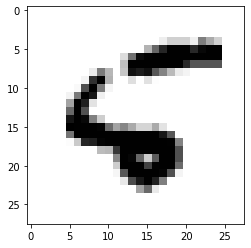

Original Labels: 5
Model prediction: 6


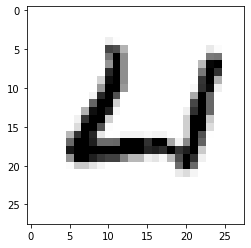

Original Labels: 4
Model prediction: 6


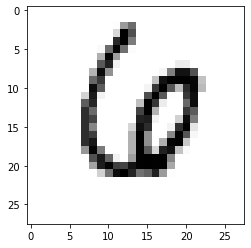

Original Labels: 6
Model prediction: 7


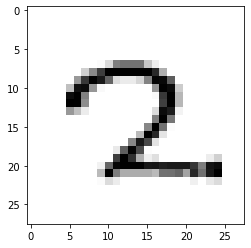

Original Labels: 2
Model prediction: 7


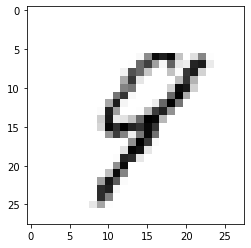

Original Labels: 9
Model prediction: 4


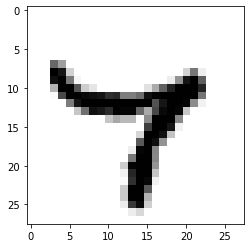

Original Labels: 7
Model prediction: 4


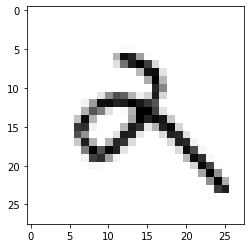

Original Labels: 2
Model prediction: 9


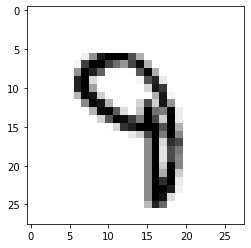

Original Labels: 9
Model prediction: 3


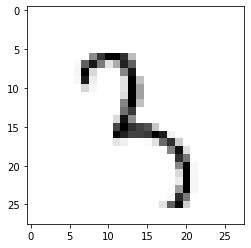

Original Labels: 3
Model prediction: 5


In [18]:
n_images = 200
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)

To be honest, I'd be a little unsure about some of those myself!

## Exercise

See if you can improve upon the accuracy. Try using more hidden neurons (nodes). Try using fewer! Try a different learning rate. Try adding another hidden layer. Try different batch sizes. What's the best accuracy you can get from this multi-layer perceptron?